![](2022-12-15-14-05-51.png)



# HDSC December '22 Premiere Project: Game of Thrones Analysis

## A Project by Team Gitlab

## Introduction

Game of Thrones, popularly known as GOT, is a hit fantasy film series based on the equally famous book series "A Song of Fire and Ice" by George RR Martin. GOT is well-known for its vastly complicated political landscape, large cast of characters, and compelling storyline. However, the film is well-known for a number of character deaths.

## Table of Content

1.<a href="#PLP"> Project Process</a></li>

2.<a href="#DC"> Data Collection</a>

3.<a href="#DEW"> Data Exploration & Wrangling</a>

4.<a href="#FE"> Feature Engineering</a>
- <a href="#feclen">Cleaning Feature</a>
- <a href="#felnk">Creating links to other data (Variables for creating features)</a>
- <a href="#fecre">Creating Feature</a>
- <a href="#fesel">Feature Selection</a>
- <a href="#undsamdata">Under sample data for model training</a>

5.<a href="#bldtrnmd"> Build and Train a Model</a>
- <a href="#mdscores">Model Test, Train and ROU-AUC Scores</a>
- <a href="#mdrecscor">Model Visualization of Recall Scores</a>
- <a href="#mdcnfmat">Model Confusion Matrices</a>
- <a href="#bmrocurv">Best Model ROC Curves</a>
- <a href="#clsrep">Classification Report of Best Models</a>

6.<a href="#HP1"> Hyper Parameter Tuning 1</a>
- <a href="#rndsecv"> Random Search with Cross Validation</a>

7.<a href="#EVPER"> Evaluate Performance of the Model</a>
- <a href="#bsper">Base Model Performance</a>
- <a href="#rndper">Performance of Best Random Search Model</a>

8.<a href="#HP2"> Hyper Parameter Tuning 2</a>
- <a href="#grdse">Grid Search with Cross Validation</a>
- <a href="#grdper1">Performance of Best Grid Search Model 1</a>

9.<a href="#HP3"> Hyper Parameter Tuning 3</a>
- <a href="#anogrdse">Another Grid Search</a>
- <a href="#grdper2">Performance of Best Grid Search Model 2</a>

10.<a href="#FM"> Final Model</a>
- <a href="#modpredin">Model Prediction and Insight</a>
- <a href="#errchar">Error Ratio by Character Features</a>

11.<a href="#SL"> Summary/Limitations</a>


## Aims and Objectives
The project's goal is to use a carefully curated dataset to predict a character's death.
In this project, we wanted to find features that are shared by all previously deceased characters and use these features to predict character deaths based on certain features.

## Data Description 

Three datasets were used for this analysis:

The first file is battles.csv, which contains Chris Albon's "The War of the Five Kings" Dataset which can be found at [here](https://github.com/chrisalbon/war_of_the_five_kings_dataset). It's an excellent collection of all of the series' battles.

Then there's Erin Pierce's and Ben Kahle's character-deaths.csv. This dataset was developed as part of Allen Downey's Bayesian Survival Analysis, which can be found at [here](http://allendowney.blogspot.com/2015/03/bayesian-survival-analysis-for-game-of-life.html).

Finally, character-predictions.csv contains a more detailed character dataset. This was scraped from [Westeros site](http://awoiaf.westeros.org/) by the team at A Song of Ice and Data.It also includes their predictions for which characters will die, the methodology of which can be found [here](https://got.show/machine-learning-algorithm-predicts-death-game-of-thrones)

<a id='PLP'></a>
## Project Flow Process
![](2022-12-15-16-15-01.png)

### Importing modules

In [1]:
# Data manipulation and wrangling package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# ML package
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier as XGBC

# Data processing package
import sklearn.utils 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, classification_report, mean_absolute_error

pd.set_option('display.max_columns', 50)

<a id='DC'></a>
## Data Collection

### Loading Data

In [2]:
battles = pd.read_csv('battles.csv')
char_deaths = pd.read_csv('character-deaths.csv')
char_pred = pd.read_csv('character-predictions.csv')

### Data Preview

In [3]:
battles.head(3)

,name,year,battle_number,attacker_king,defender_king,attacker_1,attacker_2,attacker_3,attacker_4,defender_1,defender_2,defender_3,defender_4,attacker_outcome,battle_type,major_death,major_capture,attacker_size,defender_size,attacker_commander,defender_commander,summer,location,region,note
0,Battle of the Golden Tooth,298,1,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,NaN,NaN,NaN,win,pitched battle,1.0,0.0,15000.0,4000.0,Jaime Lannister,"Clement Piper, Vance",1.0,Golden Tooth,The Westerlands,NaN
1,Battle at the Mummer's Ford,298,2,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Baratheon,NaN,NaN,NaN,win,ambush,1.0,0.0,NaN,120.0,Gregor Clegane,Beric Dondarrion,1.0,Mummer's Ford,The Riverlands,NaN
2,Battle of Riverrun,298,3,Joffrey/Tommen Baratheon,Robb Stark,Lannister,NaN,NaN,NaN,Tully,NaN,NaN,NaN,win,pitched battle,0.0,1.0,15000.0,10000.0,"Jaime Lannister, Andros Brax","Edmure Tully, Tytos Blackwood",1.0,Riverrun,The Riverlands,NaN


In [4]:
char_deaths.head(3)

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1


In [5]:
char_pred.head(3)

,S.No,actual,pred,alive,plod,name,title,male,culture,dateOfBirth,DateoFdeath,mother,father,heir,house,spouse,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,1,0,0,0.054,0.946,Viserys II Targaryen,NaN,1,NaN,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,0,0,0,0,0,1.0,0.0,0.0,NaN,0,0,NaN,11,1,1,0.605351,0
1,2,1,0,0.387,0.613,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,NaN,House Frey,Perra Royce,1,1,1,1,1,NaN,NaN,NaN,1.0,1,1,97.0,1,1,1,0.896321,1
2,3,1,0,0.493,0.507,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,0,0,0,1,0,NaN,NaN,NaN,NaN,0,1,NaN,0,0,0,0.267559,1


<a id='DEW'></a>
## Data Exploration & Wrangling

In [6]:
battles["name"].value_counts().sum()

38

In [7]:
battles["year"].min(), battles["year"].max()

(298, 300)

* There were 38 battles fought within the 3-year context of our data.
* Which of these years had the most battles?

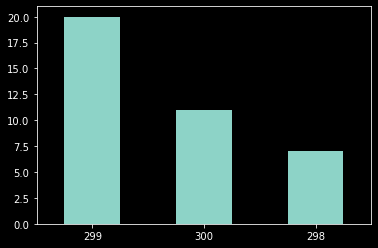

In [8]:
battles["year"].value_counts().plot(kind="bar")
plt.xticks(rotation='horizontal')
plt.show()

Most battles occured in 299BC

In [9]:
#Total wins vs losses
battles["attacker_outcome"].value_counts()

win     32
loss     5
Name: attacker_outcome, dtype: int64

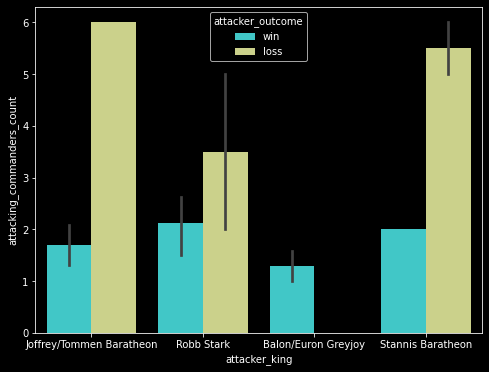

In [10]:
#The number of commanders in each battle
battles_df = battles.copy()
battles_df["attacking_commanders_count"] = [len(x) if type(x) == list else np.nan for x in battles_df.attacker_commander.str.split(",")]
#More wins with less commanders...

plt.subplots(figsize=(8, 6))
sb.barplot(x="attacker_king", y="attacking_commanders_count", hue="attacker_outcome", data=battles_df, palette="rainbow")
plt.show()

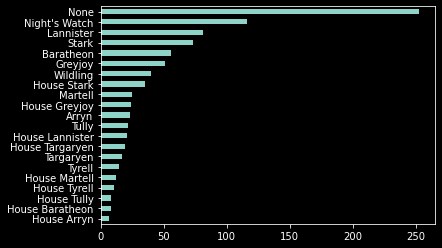

In [11]:
char_death_df = char_deaths.copy()
char_death_df.Allegiances.value_counts(ascending=True).plot(kind='barh')
plt.show()

In [12]:
alleg = char_death_df.Allegiances.unique()
alleg

array(['Lannister', 'None', 'House Targaryen', 'House Greyjoy',
       'Baratheon', "Night's Watch", 'Arryn', 'House Stark',
       'House Tyrell', 'Tyrell', 'Stark', 'Greyjoy', 'House Lannister',
       'Martell', 'House Martell', 'Wildling', 'Targaryen', 'House Arryn',
       'House Tully', 'Tully', 'House Baratheon'], dtype=object)

The presence of house causes repeated values

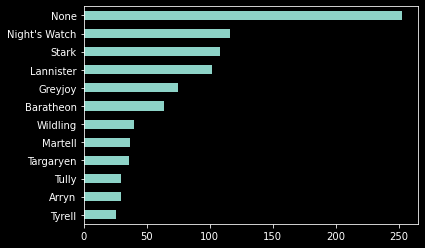

In [13]:
char_death_df['Allegiances'] = char_death_df['Allegiances'].str.replace('House ', '',)
char_death_df.Allegiances.value_counts(ascending=True).plot(kind="barh")
plt.show()


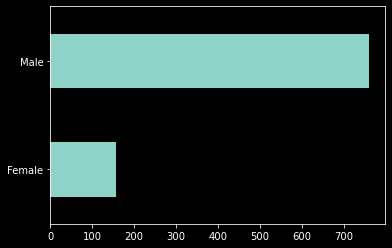

In [14]:
char_death_df["Gender"].value_counts().sort_values().plot.barh()
plt.yticks([1, 0], ['Male', 'Female'])
plt.show()

There were more male recorded deaths than female.

In [15]:
# viewing age properties
char_pred['age'].describe()

count       433.000000
mean      -1293.563510
std       19564.340993
min     -298001.000000
25%          18.000000
50%          27.000000
75%          50.000000
max         100.000000
Name: age, dtype: float64

There are negative value for date of birth. Negative mean for age.
Let's investigate that.

Research was made and according to [Fandom.com](https://gameofthrones.fandom.com/wiki/Doreah) Doreah is 25 years old.

According to [Fanthom.com](https://gameofthrones.fandom.com/wiki/Rhaego) Rhaego was never born.

In [16]:
char = char_pred.copy()

In [17]:
# Replacing the age
char.loc[1684, 'age'] = 25.0
char.loc[1868, 'age'] = 0.0

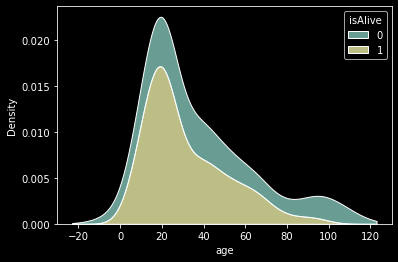

In [18]:
sb.kdeplot(data=char, x='age', hue='isAlive', multiple='stack')
plt.show()

We have more of young characters compared to adults. Also the alive density plot seems to be unimodal, while dead density plot seems to be multimodal.

In [19]:
pd.crosstab(char.male, char.isAlive)

isAlive,0,1
male,,
0,128,613
1,367,838


We have 128 dead women, 613 alive women

367 dead men and 838 alive men

Generally (128/741) * 100 = 17%. That is there is a 17% chance that a female record turns out dead.

And (367/1205) * 100 = 30.5% chance that a male record turns out dead.

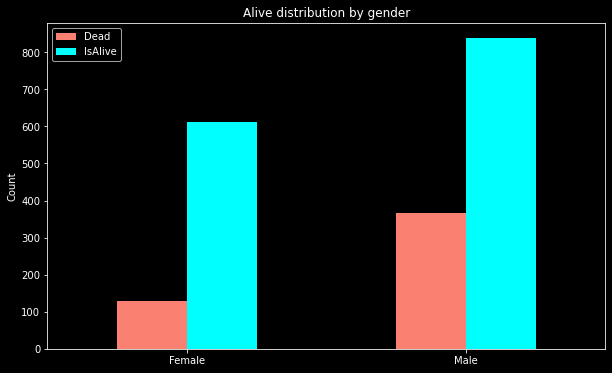

In [20]:
pd.crosstab(char.male, char.isAlive).plot(kind='bar', figsize=(10,6), color=["salmon", "cyan"])

plt.title("Alive distribution by gender")
plt.xlabel('')
plt.xticks([0,1], ['Female' , 'Male'], rotation='horizontal')
plt.ylabel("Count")
plt.legend(["Dead", "IsAlive"])
plt.show()

In [21]:
pd.crosstab(char.isPopular, char.isAlive)

isAlive,0,1
isPopular,,
0,435,1396
1,60,55


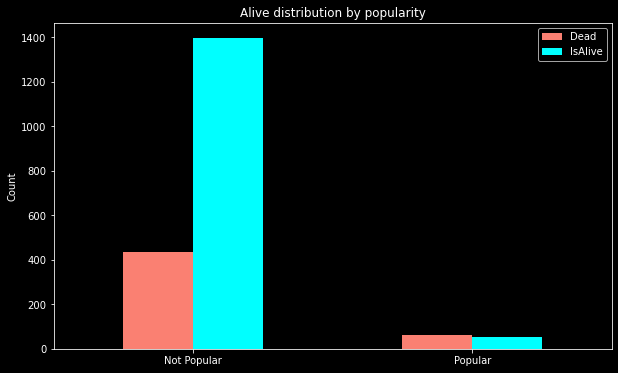

In [22]:
pd.crosstab(char.isPopular, char.isAlive).plot(kind='bar', figsize=(10,6), color=["salmon", "cyan"])

plt.title("Alive distribution by popularity")
plt.xlabel("")
plt.xticks([0,1], ['Not Popular' , 'Popular'], rotation='horizontal')
plt.ylabel("Count")
plt.legend(["Dead", "IsAlive"])
plt.show()

I guess that makes watching GOT interesting!!!

Who cares when unknown men die in battle?

But when (60/115) * 100 = 55% of people you find interesting die, Thats something(lol)

There's a low chance of a commander to die in the battle. This is so because sometimes they could be at the castle giving out commands without being physically present in the battle.

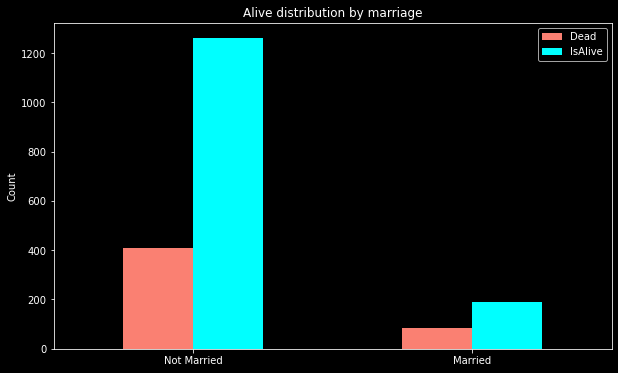

In [23]:
pd.crosstab(char.isMarried, char.isAlive).plot(kind='bar', figsize=(10,6), color=["salmon", "cyan"])

plt.title("Alive distribution by marriage")
plt.xlabel("")
plt.xticks([0,1], ['Not Married' , 'Married'], rotation='horizontal')
plt.ylabel("Count")
plt.legend(["Dead", "IsAlive"])
plt.show()

We can confirm that characters not married are more likely to die. 

<a id='FE'></a>
## Feature Engineering


<a id='feclen'></a>
### Cleaning Feature

#### Removing NaNs

In [24]:
miss = char.isna().sum()
miss[miss > 0]

title            1008
culture          1269
dateOfBirth      1513
DateoFdeath      1502
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

We have 14 columns with NaN vales. We will replace that of age with the average age value.

Replace date of birth and date of death with the median value.

Replace other categorical variable with unknown

Replace other numerical variable with -1

In [25]:
# Fill missing age with average age
char["age"].fillna(round(char["age"].mean()), inplace=True)
char['dateOfBirth'].fillna(char['dateOfBirth'].median(), inplace=True)
char['DateoFdeath'].fillna(char['DateoFdeath'].median(), inplace=True)

In [26]:
# Handling missing values in text columns
cat = ['title', 'culture', 'mother', 'father', 'heir', 'house', 'spouse']
for col in cat:
    char[col].fillna('unknown', inplace=True)
char.fillna(-1, inplace=True)

#### Duplicate cultures

Some culture are spelt wrongly thus making duplicate. E.g. 'Westermen', 'Westerman', and 'westermen' are all the same.

In [27]:
char['culture'].unique()

array(['unknown', 'Rivermen', 'Dornish', 'Valyrian', 'Ironborn',
       'Free Folk', 'Northmen', 'Summer Isles', 'Braavosi', 'Dothraki',
       'Ghiscari', 'Vale mountain clans', 'Reach', 'Tyroshi', 'Lhazarene',
       'Free folk', 'Ironmen', 'Qartheen', 'Lysene', 'westermen',
       'Westerman', 'Qarth', 'Lyseni', 'northmen', 'Qohor', 'Westeros',
       'Norvoshi', 'First Men', 'Meereenese', 'Andal', 'Astapori',
       'Westermen', 'ironborn', 'Ghiscaricari', 'Braavos', 'Stormlands',
       'Valemen', 'Myrish', 'Lhazareen', 'Dornishmen', 'Sistermen',
       'Northern mountain clans', 'Andals', 'Vale', 'Crannogmen',
       'Wildling', 'Dorne', 'Pentoshi', 'free folk', 'Summer Islander',
       'Westerlands', 'Summer Islands', 'Asshai', 'Riverlands', 'Naathi',
       'Rhoynar', 'Meereen', 'Norvos', 'Stormlander', 'Wildlings',
       'Astapor', 'Reachmen', "Asshai'i", 'Ibbenese', 'The Reach'],
      dtype=object)

In [28]:
# From  Shail Daliwala's kernel on Kaggle
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()


<a id='felnk'></a>
### Creating links to other data (Variables for creating features)
In the battle csv we have attackers and defenders, it's likely that this attackers and defenders are of powerful house in the country or region, we can create a link to characters who belongs to this house.

Also in the battles data are commanders and defenders. Having the names gathered together can help point out who is a commander and who is not. This can also play part in determining if a character, who is a commander will die.

In the character death data, it is observed that characters whom never swore allegiance died the most. We can have a column that shows if a character's house swore alliegiance to another. 

In [29]:
# Names of all Attackers
all_attackers = set(battles.attacker_1).union(set(battles.attacker_2))\
.union(set(battles.attacker_3)).union(set(battles.attacker_4))
# Names of all Defenders
all_defenders = set(battles.defender_1).union(set(battles.defender_2))

# Unique attackers and defenders combined
all_warlead = all_attackers.union(all_defenders)
all_warlead = list(all_warlead)
all_warlead.remove(np.nan)

renam_warlead = []
for x in all_warlead:
    house = 'House ' + x
    renam_warlead.append(house)
    
# All attacking commanders
all = []
for i in battles['attacker_commander'].dropna().values:
    splitted = i.split(', ')
    all +=splitted
    
all_att_commanders = set(all)

# All defending commanders
all = []
for i in battles['defender_commander'].dropna().values:
    splitted = i.split(', ')
    all +=splitted
    
all_def_commanders = set(all)

# All commanders 
all_commanders = all_att_commanders.union(all_def_commanders)
# characters who swore allegiance in character death data
char_with_allgnc = char_deaths[char_deaths['Allegiances'] != 'None']

# Extracting the above character from all character data
all_char_with_allgnc = char_pred[char_pred['name'].isin(char_with_allgnc['Name'])]

# house of character with allegiance to another house (house in character dead allegiance column)
hus_char_with_allegnc = all_char_with_allgnc['house']

# Extract unique house of allegiance from charater death data.
husOfAllgnc = list(set(char_deaths['Allegiances']))
husOfAllgnc.remove('None')

renam_husOfAllgnc = []
for x in husOfAllgnc:
    house = 'House ' + x
    renam_husOfAllgnc.append(house)


<a id='fecre'></a>
### Creating Feature

In [30]:
# Characters that are commanders.
char['isACommander'] = np.where(char['name'].isin(all_commanders), 1, 0)
# Characters that belong to the house of either the attacker or defender
char['inHouseOfWarLead'] = np.where(char['house'].isin(renam_warlead), 1, 0)
# Characters whose house swore alliegiance to another house
char['houseSworeAllegiance'] = np.where(char['house'].isin(hus_char_with_allegnc), 1, 0)
# House of alliegiance, characters that belong to those house
char['inHouseOfAllegnc'] = np.where(char['house'].isin(renam_husOfAllgnc), 1, 0)

# Dropping redundant columns
char = char.drop(['S.No', 'actual', 'pred', 'alive', 'plod', 'dateOfBirth',
                  'DateoFdeath', 'house'], axis=1)
char.set_index('name', inplace=True)


In [31]:
# save character details
char.to_csv('GOT_Char_details.csv')

<a id='fesel'></a>
### Feature Selection

In [32]:
new = char.copy()

#### Feature Correlation

In [33]:
# Checking correlation of numerical featres with the target variable.
num_features = new.select_dtypes(['int', 'float'])
corr_mat = num_features.corr()['isAlive'].abs().sort_values()
corr_mat

book3                   0.006693
inHouseOfWarLead        0.029822
isAliveSpouse           0.031536
book5                   0.032846
isNoble                 0.042211
isMarried               0.050037
houseSworeAllegiance    0.052159
isACommander            0.057968
book2                   0.067200
inHouseOfAllegnc        0.113380
isAliveHeir             0.116365
isAliveFather           0.123615
age                     0.136891
isAliveMother           0.140661
male                    0.146982
book1                   0.147401
isPopular               0.153860
popularity              0.183223
numDeadRelations        0.192444
boolDeadRelations       0.193736
book4                   0.268975
isAlive                 1.000000
Name: isAlive, dtype: float64

We can see that the correlation ranges from 0.006 t0 0.2

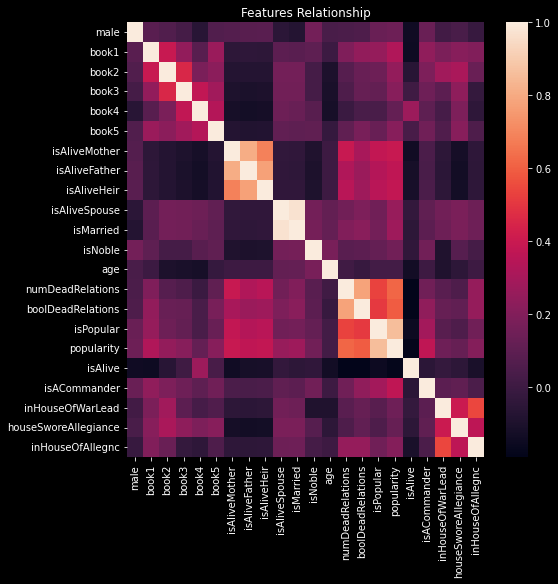

In [34]:
# Heatmap of numerical feature in the training dataset
plt.figure(figsize=(8, 8))
num_features = new.select_dtypes(['int', 'float'])
corr_mat = num_features.corr()
sb.heatmap(data=corr_mat)
plt.title('Features Relationship')
plt.show()

#### Feature Multicollinearity

From the heatmap above, we can spot some multicollinearity (Multicollinearity refers to the statistical phenomenon where two or more independent variables are strongly correlated) amongst features. 

Let's view them using the Variance Inflation Factor (VIF)

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x = num_features.drop(columns='isAlive')
vif = pd.DataFrame()
vif['features'] = x.columns

vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
vif.sort_values(by='VIF', ascending=False)

,features,VIF
7,isAliveFather,165.111250
6,isAliveMother,93.203589
8,isAliveHeir,77.020836
9,isAliveSpouse,28.026185
10,isMarried,15.455632
12,age,10.098704
16,popularity,7.642320
15,isPopular,4.347781
19,houseSworeAllegiance,3.579165
4,book4,3.242501


Let's drop some columns with multicolinearity. 

Then we will go with features that has a correlation greater than 0.1

In [36]:
# Dropping columns with colinearity
new = new.drop(['isAliveFather', 'isAliveMother', 'isAliveSpouse'], axis=1)

In [37]:
# Selecting features with coefficient greater than 0.1
num_features = new.select_dtypes(['int', 'float'])
corr_mat = num_features.corr()['isAlive'].abs().sort_values()
corr_less = corr_mat[corr_mat < 0.1]
corr_less

book3                   0.006693
inHouseOfWarLead        0.029822
book5                   0.032846
isNoble                 0.042211
isMarried               0.050037
houseSworeAllegiance    0.052159
isACommander            0.057968
book2                   0.067200
Name: isAlive, dtype: float64

In [38]:
new = new.drop(corr_less.index, axis=1)

#### Feature Dummies

In [39]:
# List of categorical variable
nominal_features = ['title', 'culture', 'mother', 'father', 'heir', 'spouse']

# Counting unique values in each column
unique_count = new[nominal_features].apply(lambda x: len(x.value_counts())).sort_values()

In [40]:
# Arbitrary cutoff of 25 unique count
unique_count = unique_count[unique_count > 25].index
# Dropping 
new = new.drop(unique_count, axis=1)

In [41]:
# Converting the remaining text column to categorical type
txt_col = new.select_dtypes(include=['object'])
for col in txt_col:
    new[col] = new[col].astype('category')
    
# Creating dummy columns from txt columns and add back to dataframe
new = pd.concat([
    new, pd.get_dummies(new.select_dtypes(include=['category']))
], axis=1).drop(txt_col, axis=1)

In [42]:

character = char_pred.copy()
def transform_data(data):
    # Replacing the age
    data.loc[1684, 'age'] = 25.0
    data.loc[1868, 'age'] = 0.0
    
    # Replacing missing values
    data["age"].fillna(round(data["age"].mean()), inplace=True)
    data['dateOfBirth'].fillna(data['dateOfBirth'].median(), inplace=True)
    data['DateoFdeath'].fillna(data['DateoFdeath'].median(), inplace=True)
    
    data.loc[:, "culture"] = [get_cult(x) for x in data.culture.fillna("")]
    cat = ['title', 'mother', 'father', 'heir', 'house', 'spouse']
    for col in cat:
        data[col].fillna('unknown', inplace=True)
    data.fillna(-1, inplace=True)
    
    data['isACommander'] = np.where(data['name'].isin(all_commanders), 1, 0)
    data['inHouseOfWarLead'] = np.where(data['house'].isin(renam_warlead), 1, 0)
    data['houseSworeAllegiance'] = np.where(data['house'].isin(hus_char_with_allegnc), 1, 0)
    data['inHouseOfAllegnc'] = np.where(data['house'].isin(renam_husOfAllgnc), 1, 0)
    
    data = data.drop(['S.No', 'actual', 'pred', 'alive', 'plod', 'title',
                      'dateOfBirth', 'DateoFdeath', 'house'], axis=1)
    
    return data

def select_features(data):
    data.set_index('name', inplace=True)
    # Heatmap of numerical feature in the training dataset
    num_features = data.select_dtypes(['int', 'float'])
    corr_mat = num_features.corr()['isAlive'].abs().sort_values()
    corr_less = corr_mat[corr_mat < 0.1]
    data = data.drop(corr_less.index, axis=1)
    
    # Dropping columns with colinearity
    data = data.drop(['isAliveFather', 'isAliveMother'], axis=1)
    
    # List of categorical variable
    nominal_features = ['culture', 'mother', 'father', 'heir', 'spouse']
    # Counting unique values in each column
    unique_count = data[nominal_features].apply(lambda x: len(x.value_counts())).sort_values()
    unique_count = unique_count[unique_count > 25].index
    # Dropping 
    data = data.drop(unique_count, axis=1)
    # Converting the remaining text column to categorical type
    txt_col = data.select_dtypes(include=['object'])
    for col in txt_col:
        data[col] = data[col].astype('category')
        
    # Creating dummy columns from txt columns and add back to dataframe
    data = pd.concat([
        data, pd.get_dummies(data.select_dtypes(include=['category']))
    ], axis=1).drop(txt_col, axis=1)
    
    return data
    
transformed_data = transform_data(character)
selected_features = select_features(transformed_data)

selected_features

,male,book1,book4,isAliveHeir,age,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive,inHouseOfAllegnc,mother_Alicent Hightower,mother_Alyssa Targaryen,mother_Alyssa Velaryon,mother_Betha Blackwood,mother_Cassana Estermont,mother_Catelyn Stark,mother_Cersei Lannister,mother_Daenaera Velaryon,mother_Dyanna Dayne,mother_Lady of House Sunderly,mother_Mariah Martell,mother_Naerys Targaryen,mother_Rhaenyra Targaryen,mother_Rhaenys Targaryen,...,father_Viserys I Targaryen,father_unknown,heir_Aegon IV Targaryen,heir_Aegon Targaryen,heir_Aemon Targaryen,heir_Aenys Targaryen,heir_Aerys II Targaryen,heir_Arlan V Durrandon,heir_Baelor 'Breakspear' Targaryen,heir_Baelor I Targaryen,heir_Bran Stark,heir_Daeron I Targaryen,heir_Daeron II Targaryen,heir_Duncan Targaryen,heir_Durran the Devout,heir_Halleck Hoare,heir_Jaehaerys Targaryen,heir_Myrcella Baratheon,heir_Rhaegar Targaryen,heir_Rhaegel Targaryen,heir_Rhaenyra Targaryen,heir_Shireen Baratheon,heir_Theon Greyjoy,heir_Tommen Baratheon,heir_unknown
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Viserys II Targaryen,1,0,0,0.0,37.0,11,1,1,0.605351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walder Frey,1,1,1,-1.0,97.0,1,1,1,0.896321,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Addison Hill,1,0,1,-1.0,37.0,0,0,0,0.267559,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Aemma Arryn,0,0,0,-1.0,23.0,0,0,0,0.183946,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Sylva Santagar,0,0,1,-1.0,29.0,0,0,0,0.043478,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Luwin,1,1,1,-1.0,37.0,0,0,1,0.351171,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Reek,1,0,1,-1.0,37.0,0,0,0,0.096990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Symeon Star-Eyes,1,1,1,-1.0,37.0,0,0,0,0.030100,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Save cleaned data

In [43]:
selected_features.to_csv('cleaned_got_for_ml1.csv')

<a id='undsamdata'></a>
### Under sample data for model training

In [44]:
selected_features.isAlive.value_counts()

1    1451
0     495
Name: isAlive, dtype: int64

The target variable is imbalance, there are more people alive than dead. To handle this, we will undersample the majority class.

In [45]:
dead = selected_features[selected_features['isAlive'] == 0]
alive = selected_features[selected_features['isAlive'] == 1].sample(500, random_state=42)
und_samp_df = pd.concat([dead, alive])

und_samp_df = sklearn.utils.shuffle(und_samp_df, random_state=42)
und_samp_df1 = und_samp_df.copy()
# und_samp_df = und_samp_df.reset_index(drop=True)
und_samp_df.shape

(995, 73)

In [46]:
und_samp_df.isAlive.value_counts()

1    500
0    495
Name: isAlive, dtype: int64

In [47]:
# Scaling our data
scaler = StandardScaler()
norm_df = scaler.fit_transform(und_samp_df)
norm_df = pd.DataFrame(norm_df, columns=und_samp_df.columns)
norm_df.index = und_samp_df1.index
norm_df['isAlive'] = und_samp_df['isAlive']

In [48]:
# Creating Features and Target
x = norm_df.drop(columns='isAlive')
y = norm_df['isAlive']


In [49]:
# Splitting the data for model training 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, shuffle=True, random_state=5, stratify=y)

In [50]:
y_train.value_counts()

1    350
0    346
Name: isAlive, dtype: int64

<a id='bldtrnmd'></a>
## Build and Train a Model

In [51]:
# creating a seed
fixed_seed = 42

# Models for training
models = [LogisticRegression(random_state=fixed_seed), KNeighborsClassifier(), RandomForestClassifier(random_state=fixed_seed),
          DecisionTreeClassifier(random_state=fixed_seed),  XGBC(seed=fixed_seed)]

test_score = []
train_score = []
roc_auc_lst = []

# Loops through each mosel and get their score
for model in models:
    model.fit(x_train, y_train)
    proba = model.predict_proba(x_test)[:, 1]
    test = model.score(x_test, y_test)
    train = model.score(x_train, y_train)
    roc_auc = roc_auc_score(y_test, proba)
    test_score.append(test)
    train_score.append(train)
    roc_auc_lst.append(roc_auc)

<a id='mdscores'></a>
### Models Test, Train and ROU-AUC Score

In [52]:
models_score = {
    'Train Score': train_score,
    'Test_Score': test_score,
    "ROC_AUC Score": roc_auc_lst
}
pd.DataFrame(models_score, index=['LogisticRegression','KNeighborsClassifier', 'RandomForestClassifier', 
                              'DecisionTreeClassifier', 'XGBC'])

,Train Score,Test_Score,ROC_AUC Score
LogisticRegression,0.709770,0.648829,0.724318
KNeighborsClassifier,0.784483,0.682274,0.737987
RandomForestClassifier,0.896552,0.692308,0.746711
DecisionTreeClassifier,0.896552,0.675585,0.697673
XGBC,0.873563,0.688963,0.762461


We can see that some feature are performing well than the other, both on the training set and testing set. We will be working with the ROC-AUC score because this shows the ability of the model to distinguish between classes. The higher the score the better the model is at distinguishing between character that are dead and alive.

Let's see the recall score for each of the model

<a id='mdrecscor'></a>
### Models Visualization of Recall Score  

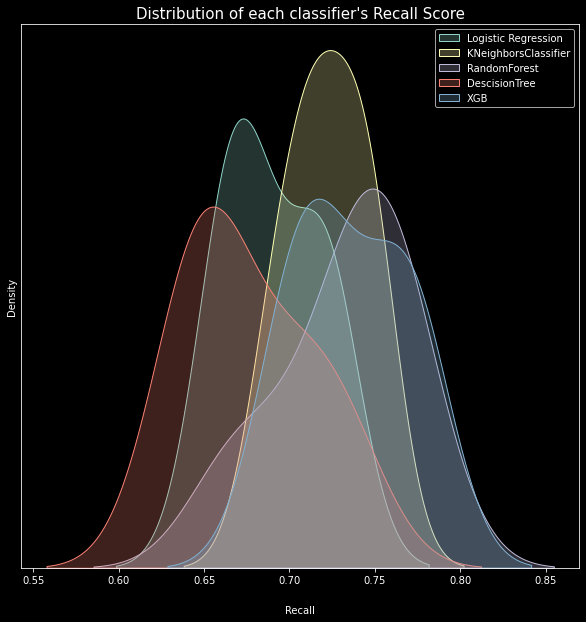

In [53]:
# Using stratified kfold to get the recall of each model
skf = StratifiedKFold(n_splits= 5 , shuffle= True , random_state= fixed_seed ) 
recall=[]
for model in models:
    result = cross_val_score(model, x, y, cv=skf, scoring="recall", n_jobs=-1)
    recall.append(result)
classifiers=['Logistic Regression', 'KNeighborsClassifier', 'RandomForest', 'DescisionTree', 'XGB']

plt.figure(figsize=(10, 10))
for x in range(len(recall)):
    sb.kdeplot(recall[x], shade=True)
    
plt.title("Distribution of each classifier's Recall Score", fontsize=15)
plt.legend(classifiers)
plt.xlabel("Recall", labelpad=20)
plt.yticks([])

plt.show()

From the above we can see the probabilty density of recall score for each model. Random forest classifier has a unimodal shape, and has the longest peak. 

XGBClassifier and Random forest classifier seems to have the highest recall score though low density compared to Logistic regression and Random forest classifier.

We will proceed with the models with higher AUC-ROC score, and check their confusion metrics

<a id='mdcnfmat'></a>
### Models Confusion Matrices

In [54]:
# Models with AUC-ROC score > 0.7
sub_models = [LogisticRegression(random_state=fixed_seed), KNeighborsClassifier(), RandomForestClassifier(random_state=fixed_seed), XGBC(seed=fixed_seed)]
# Getting the confusion metric for each model 
cm = []
for model in sub_models:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    model_cm = confusion_matrix(y_test, pred)
    cm.append(model_cm)

In [55]:
# Function to plot heatmap
def cm_heatmap(cm, ax, r, c, model):
    title = str(sub_models[model]).split('(')[0]
    ax[r,c].set_title(f"{title} Confusion Matrix", fontsize=15.)
    fig = sb.heatmap(cm, square = True, xticklabels = ["Deceased", "Alive"], annot = True, ax=ax[r,c],
                    annot_kws = {"fontsize": 13}, yticklabels = ["Deceased", "Alive"],
                    cbar = True, cbar_kws = {"orientation": "vertical"}, cmap = "BrBG", fmt='d').set(
        xlabel = "Predicted Class", ylabel = "Actual Class",)
    return fig

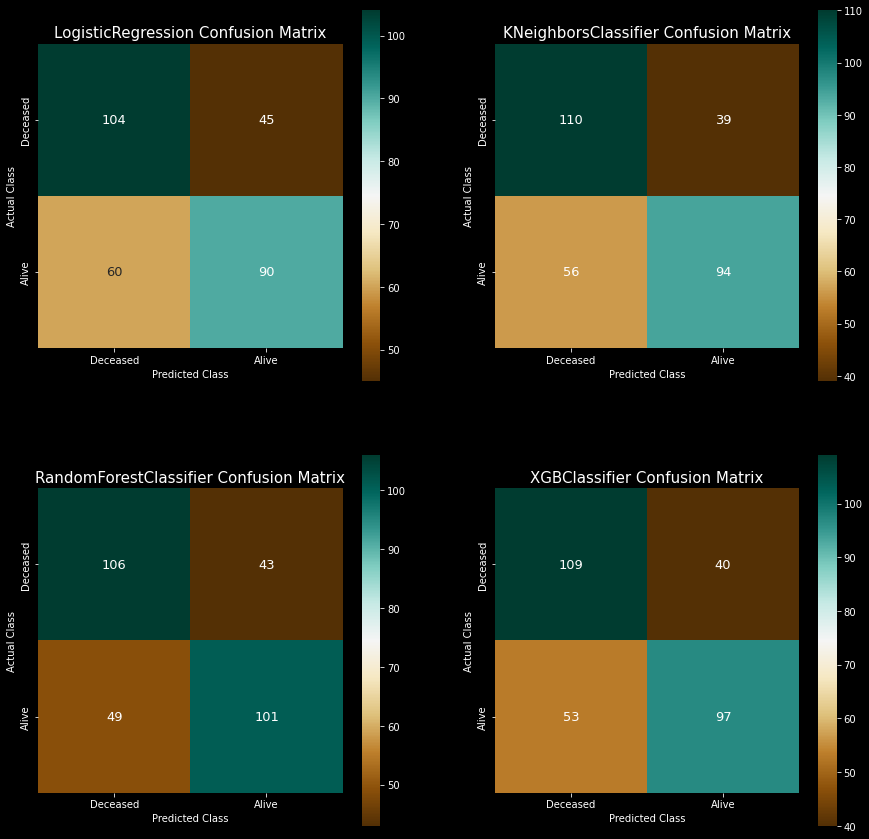

In [56]:

# Displaying confusion metrics
f, ax = plt.subplots(2, 2, figsize=(15, 15))
cm_heatmap(cm[0], ax, 0, 0, 0)
cm_heatmap(cm[1], ax, 0, 1, 1)
cm_heatmap(cm[2], ax, 1, 0, 2)
cm_heatmap(cm[3], ax, 1, 1, 3)
plt.show()

Above we can see the confusion matrix for each models.

Logistic Regression has the highest False Positive (60) and lowest True Negative (90) compared to other models. 

KNeighbors Classifier is performing well in detecting characters that are dead (True Positive 110) compared to other models. It also has the lowest False Negative (39).

Amongst the four model, Random Forest Classifier is the only model with the highest True negative (101). Its False Positive (49) is lower than the aforementioned two models.

XGBClassifier is the second model with the highest True Positive (109), a difference of 1 compared to KNeighbors Classifier. Its also the second model with the highest True Negative (97).

Moving on, we will only consider two models from the above four. It's very clear that Logistic Regression model is not performing well with our data. 

We will proceed with Random Forest Classifier and XGBClassifier because, comparing the TP and TN amognst all four models, both has the highest number if joined together. 

<a id='bmrocurv'></a>
### Best Model ROC Curve

We have seen that Random Forest Classifier and XGBC are perfoming well with our data. We'll choose the two models and proceed.

Let's start by looking at the ROC curve of the two models

In [57]:
# Two best model based on AUC-ROC score and confusion matrix observation.
best_model = [RandomForestClassifier(random_state=fixed_seed), XGBC(seed=fixed_seed)]
# ROC curve for each model
roc = []
for model in best_model:
    model.fit(x_train, y_train)
    proba = model.predict_proba(x_test)[:, 1]
    roc_cur = roc_curve(y_test, proba)
    roc.append(roc_cur)

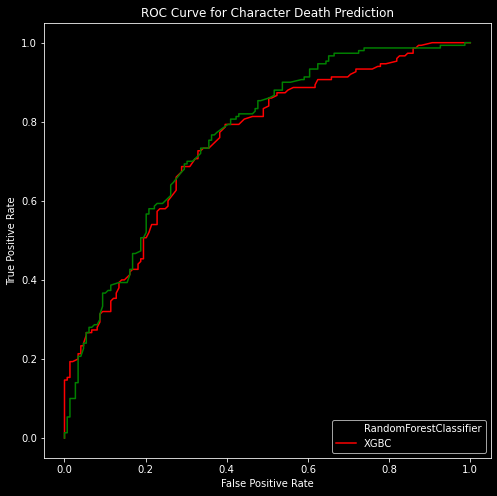

In [58]:
# Plotting ROC curve for the models
fig = plt.figure(figsize=(8, 8))
fpr1, tpr1, thresholds1 = roc[0]
fpr2, tpr2, thresholds2 = roc[1]

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr1, tpr1, color='r')
plt.plot(fpr2, tpr2, color='g')
plt.legend(['RandomForestClassifier', 'XGBC'], loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Character Death Prediction')
plt.show()

We've seen how the curve look like. Both models seems to be competing. Random Forest Classifier seems to cover more area than XGBClassifier.

Let's see their classification report.

<a id='clsrep'></a>
### Classification Report of Best Models

In [59]:
for model in best_model:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    print(str(model).split('(')[0] +' Test Performance')
    cls_rep = classification_report(y_test, pred, target_names=['Dead', 'Alive'])
    print(cls_rep)
    print('='*40)

RandomForestClassifier Test Performance
              precision    recall  f1-score   support

        Dead       0.68      0.71      0.70       149
       Alive       0.70      0.67      0.69       150

    accuracy                           0.69       299
   macro avg       0.69      0.69      0.69       299
weighted avg       0.69      0.69      0.69       299

XGBClassifier Test Performance
              precision    recall  f1-score   support

        Dead       0.67      0.73      0.70       149
       Alive       0.71      0.65      0.68       150

    accuracy                           0.69       299
   macro avg       0.69      0.69      0.69       299
weighted avg       0.69      0.69      0.69       299



From the test performance above, we can see that both models share lots of similarity, such as having the same accuracy, same f1 score for dead category, same macro avg, and weighted avg.

Comparing the precision and recall score the maximum difference they have is 2. 

we will proceed to tuning Random Forest Classifier for better performance. 

<a id='HP1'></a>
## Hyper Parameter Tuning 1

We are going to tune Random Forest Classifier model to get it's best performance. Some ranges of parameters will be giving, then a random search will be done on those parameters for the best.

<a id='rndsecv'></a>
### Random Search with Cross Validation

In [60]:
random_grid = {'bootstrap': [True, False],
                'max_depth': [20, 40, 60, 80,],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
                'criterion': ["gini", "entropy"],
                'n_estimators': [200, 400, 600, 800,],
                }

In [61]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state=fixed_seed)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                                random_state=fixed_seed, n_jobs = -1, scoring='neg_mean_absolute_error')
# Fit the random search model
rfc_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 40, 60, 80],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [62]:
# Best Parameters from random search
rfc_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'criterion': 'gini',
 'bootstrap': False}

<a id='EVPER'></a>
## Evaluate Performance of the Model

In [63]:
# Function to calculate model average error and accuracy
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('='*30)
    avg_error = 'Average Error: {:0.4f} degrees.'.format(np.mean(errors))
    print(avg_error)
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: {:0.2f}%.'.format(100 * accuracy))
    
    return [np.mean(errors), accuracy]

# Function to show model performance difference
def improvement(new_score, base):
    print('Improvement Error: {:0.2f}%.'.format( 100 * (new_score[0] - base[0]) / base[0]))
    print('Improvement Accuracy: {:0.2f}%.'.format( 100 * (new_score[1] - base[1]) / base[1]))
    print('=' * 30)


<a id='bsper'></a>
#### Base Model Performance

In [64]:
base_model = RandomForestClassifier(n_estimators = 100, random_state = fixed_seed)
base_model.fit(x_train, y_train)
base_performance = evaluate(base_model, x_test, y_test)

Model Performance
Average Error: 0.3077 degrees.
Accuracy: 69.23%.


<a id='rndper'></a>
#### Performance of Best Random Search Model

In [65]:
best_random = rfc_random.best_estimator_
random_performance = evaluate(best_random, x_test, y_test)
improvement(random_performance, base_performance)

Model Performance
Average Error: 0.3010 degrees.
Accuracy: 69.90%.
Improvement Error: -2.17%.
Improvement Accuracy: 0.97%.


<a id='HP2'></a>
## Hyper Parameter Tuning 2
Now let's do a grid search around the best parameter gotten from the random search

<a id='grdse'></a>
### Grid Search with Cross Validation

In [66]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [50, 60],
    'max_features': ['auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [200, 400, 600],
    'criterion': ["gini"]
}
# Create a based model
rfc = RandomForestClassifier(random_state=fixed_seed)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, 
                           n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [50, 60], 'max_features': ['auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 400, 600]},
             scoring='neg_mean_absolute_error', verbose=2)

In [67]:
# Best parameter from grid search 
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

<a id='grdper1'></a>
#### Performance of Best Grid Search Model 1

In [68]:
best_grid = grid_search.best_estimator_
grid_performance = evaluate(best_grid, x_test, y_test)
improvement(grid_performance, base_performance)

Model Performance
Average Error: 0.3077 degrees.
Accuracy: 69.23%.
Improvement Error: 0.00%.
Improvement Accuracy: 0.00%.


It seems we have about maxed out performance given the fact that ther is no improvement on error and acccuracy, but we can give it one more try with a grid further refined from our previous results.

<a id='HP3'></a>
## Hyper Parameter Tuning 3

<a id='anogrdse'></a>
#### Another Grid Search

In [69]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [40, 50,],
    'max_features': ['auto'],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 200, 300],
    'criterion': ["gini"]
}
# Create a based model
rfc = RandomForestClassifier(random_state=fixed_seed)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 3, 
                           n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [40, 50], 'max_features': ['auto'],
                         'min_samples_leaf': [5, 6, 7],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [70]:
# Best performance from second grid search
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 100}

<a id='grdper2'></a>
#### Performance of Best Grid Search Model 2

In [71]:
best_grid = grid_search.best_estimator_
grid_performance2 = evaluate(best_grid, x_test, y_test)
improvement(grid_performance2, base_performance)

Model Performance
Average Error: 0.2910 degrees.
Accuracy: 70.90%.
Improvement Error: -5.43%.
Improvement Accuracy: 2.42%.


A big decrease in performance, yet the same best parameters was given. This indicates we have reached diminishing returns for hyperparameter tuning. We could continue, but the returns would be the same output in terms of parameters.

<a id='FM'></a>
## Final Model 

In [72]:
final_model = grid_search.best_estimator_
print('Final Model Parameter:')
print('='*30)
print(final_model.get_params())
print('='*30)
grid_final_accuracy = evaluate(final_model, x_test, y_test)

Final Model Parameter:
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Model Performance
Average Error: 0.2910 degrees.
Accuracy: 70.90%.


<a id='modpredin'></a>
### Model Prediction and Insight
Below we create a pipeline to create a model using the best parameter from the final model above, then make predictions

In [73]:
# Splitting under sample data
train = und_samp_df[:696].copy()
test = und_samp_df[696:].copy()
# Creating features
features = train.columns.drop('isAlive')
# Instantiate random forest model
rndfrst = RandomForestClassifier(bootstrap=False, criterion='gini',
                                 max_depth=40, max_features='auto', 
                                 min_samples_leaf=5, min_samples_split=2,
                                 n_estimators=100, random_state=42, 
                                 )

# Build the steps
steps = [("scaler", StandardScaler()),
         ("rndfrst", rndfrst)]

# create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training data
pipeline.fit(train[features], train['isAlive'])

# Make predictions on the test set
rndfrst_pred1 = pipeline.predict(test[features])
# Add predictions to test data
test['predictions'] = rndfrst_pred1
# Checking mean absolute error
mae = mean_absolute_error(test['isAlive'], test['predictions'])
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.2842809364548495


Below we check visually how the model is performing for some character with acertain feature, by comparing the main labels with the predictions

In [74]:
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as gob
import plotly.offline as po
po.init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
from plotly.subplots import make_subplots

In [75]:
char_dt = pd.read_csv('GOT_Char_details.csv', index_col=0)

In [76]:
test_copy = test.copy()
test_copy['male'].replace({0:'Female', 1:'Male'}, inplace=True)
test_copy['isAlive'].replace({0:'Dead', 1:'Alive'}, inplace=True)
test_copy['predictions'].replace({0:'Dead', 1:'Alive'}, inplace=True)
test_copy['isPopular'].replace({0:'Not Popular', 1:'Popular'}, inplace=True)

In [77]:
def grouper(col):
    orig = test_copy.groupby(col, as_index=False)[['isAlive']].value_counts(normalize=True)
    orig['proportion'] = orig['proportion'].round(3)
    pred = test_copy.groupby(col, as_index=False)[['predictions']].value_counts(normalize=True)
    pred['proportion'] = pred['proportion'].round(3)
    return[orig, pred]

def sep_plot(org, prd, col, val1, val2):
    a = org[org[col] == val1]
    c = prd[prd[col] == val1]
    b = org[org[col] == val2]
    d = prd[prd[col] == val2]
    
    fig = gob.Figure(gob.Bar(x=a.isAlive, y=a.proportion, name='Main label', text=a.proportion))
    fig.add_trace(gob.Bar(x=c.predictions, y=c.proportion, name='Pred label', text=c.proportion))
    fig.update_layout(barmode='group', width=500, title=f'{val1} Character Prediction Comparison')
    fig.update_yaxes(showticklabels=False)
    fig.show()
    
    fig = gob.Figure(gob.Bar(x=b.isAlive, y=b.proportion, name='Main label', text=b.proportion))
    fig.add_trace(gob.Bar(x=d.predictions, y=d.proportion, name='Pred label', text=d.proportion))
    fig.update_layout(barmode='group', width=500, title=f'{val2} Character Prediction Comparison')
    fig.update_yaxes(showticklabels=False)
    fig.show()

In [78]:
gp = grouper('male')
sep_plot(gp[0], gp[1], 'male', 'Male', 'Female')


In [79]:
gp = grouper('isPopular')
sep_plot(gp[0], gp[1], 'isPopular', 'Popular', 'Not Popular')

The above plots show the comparison of main label and prediction in terms of proportion. We can also see the small differnce between the two, also in popular character, the model wasn't performing well

Below we will look at some characters with a certain feature and their prediction in a tabuler form, that way we can know if the prediction is quite accurate for each characters

In [80]:
ne = char_dt[char_dt.index.isin(test.index)]
ne['pred'] = test['predictions']

In [81]:
# viewing predictions for characters that are commanders
commander = ne[ne['isACommander'] == 1]
commander[['isAlive', 'pred']]

,isAlive,pred
name,,
Leobald Tallhart,0,1
Halys Hornwood,0,1
Leo Lefford,0,1
Lyle Crakehall,1,1
Amory Lorch,0,0
Donal Noye,0,0
Edmure Tully,1,0
Gregor Clegane,0,0
Jacelyn Bywater,0,1


In [82]:
# viewing predictions for characters that are commanders
commander = ne[ne['isACommander'] == 0]
commander[['isAlive', 'pred']][:10]

,isAlive,pred
name,,
Aemma Arryn,0,0
Wilbert,0,1
Wynafryd Manderly,1,1
Yorko Terys,1,1
Maegor I Targaryen,0,0
Randa,1,1
Rast,0,0
Raymond Nayland,1,1
Redtusk,1,0


In [83]:
# viewing predictions for characters that are in house of allegiance
huz_of_allgnc = ne[ne['inHouseOfAllegnc'] == 1]
huz_of_allgnc[['isAlive', 'pred']][:10]

,isAlive,pred
name,,
Aemma Arryn,0,0
Red Rolfe,0,0
Rhaenys Targaryen (daughter of Aemon),0,0
Victor Tyrell,1,1
Werlag,1,1
Aegon Targaryen (son of Jaehaerys I),0,0
Alebelly,0,0
Becca,1,1
Belandra,1,1


In [84]:
# viewing predictions for characters that their house swore allegiance
swore_alleg = ne[ne['houseSworeAllegiance'] == 0]
swore_alleg[['isAlive', 'pred']][:10]

,isAlive,pred
name,,
Wilbert,0,1
Yorko Terys,1,1
Maegor I Targaryen,0,0
Randa,1,1
Raymond Nayland,1,1
Redtusk,1,0
Rolfe,1,1
Runciter,0,0
Stone Thumbs,0,1


<a id='errchar'></a>
### Error Ratio by Character Features
It's difficult to tell the number of error by looking at the table as it is above, so we will look at the error ratio for sets of character with a particular feature.

In [85]:
errors = (ne['isAlive'] - ne['pred']).abs()
def error_ratio(col):
    # error by feature 
    er = errors.groupby(ne[col]).mean()
    # average people by feature
    avg = ne['isAlive'].groupby(ne[col]).mean()
    err_ratio = er/avg
    return err_ratio
print(error_ratio('isACommander'))
print('='*20)
print(error_ratio('inHouseOfAllegnc'))
print('='*20)
print(error_ratio('inHouseOfWarLead'))
print('='*20)
print(error_ratio('isPopular'))

isACommander
0    0.50
1    1.75
dtype: float64
inHouseOfAllegnc
0    0.517730
1    0.631579
dtype: float64
inHouseOfWarLead
0    0.514925
1    0.615385
dtype: float64
isPopular
0    0.512987
1    1.000000
dtype: float64


We can see from above that the error ratio is high for characters that are commanders, and low for those that are not. It is the same for characters with popularity and that are not, high and low error ratio respectively.

<a id='SL'></a>
## Summary
1. There were 38 battles fought within 3-year context of our data
2. Characters without alleigiance to any house has the highest death count, followed by the nights watch.
3. From the characters data, we have 128 dead women, 618 alive women, 367 dead men, and 838 alive men.
4. There is a 17% chance that a female record turns out dead, and there is 30.5% chance a male record turns out dead.
5. In other to link the battle and character death deatails to the characters data, 4 features were created.
    * Feature to show characters who were commanders.
    * Feature to show characters who belong to house of war attackers an defenders.
    * Feature to show characters who belong to one of the house of allegiance.
    * Feature to show characters who house swore alliegiance to another house.
>
6. The data was under sampled because of the label feature was imbalance 1,451 and 495 for alive and dead charaters respectively. After undersampling we had 500 and 495 for alive and dead characters respectively.
7. The data was trained on five (5) classification model, and the following score was gotten for each:

|Models|Train Score| Test_Score	|ROC_AUC Score|
|---|:---:|:---:|:--:|
LogisticRegression	| 0.709770	| 0.648829 |	0.724318
KNeighborsClassifier|	0.784483 |	0.682274 |	0.737987
RandomForestClassifier|	0.896552 |	0.692308 |	0.746711
DecisionTreeClassifier|	0.896552 | 0.675585 |0.697673
XGBC	| 0.873563 | 0.688963 |	0.762461
>
8. Out of the five model, two of them (Random Forest Classifier and XGBClassifier) was performing better than the other, below is their performance on the test data:

Random Forest Classifier Test Performance: Accuracy 69%  

| Character | precision | recall | f1-score |
|---|---|---|---|
|Dead       |0.68  |    0.71  |    0.70   |    149
|Alive       |0.70|      0.67  |    0.69 |      150
>
XGBClassifier Test Performance: Accuracy 69%

|Character| precision | recall |  f1-score |
|---|---|---|---|
|Dead   |    0.67   |   0.73   |   0.70    
|Alive |       0.71  |    0.65   |   0.68  
>
9. Random Forest classifier was chosen as the model of interest, and its parameter was tuned using Random Search Cross Validation and Grid Search Cross Validaton, for best results. Below are the performance after tuning:
* Base Model Performance
>
>Average Error: 0.3077 degrees.
>
>Accuracy: 69.23%.

* Fine-Tuning Model 1 Performance (RandomSearchCV)
>
>Average Error: 0.3010 degrees.
>
>Accuracy: 69.90%.
>
>Improvement Error: -2.17%.
>
>Improvement Accuracy: 0.97%.

* Fine-Tuning Model 2 Performance (GridSearchCV)
>
>Average Error: 0.3077 degrees.
>
>Accuracy: 69.23%.
>
>Improvement Error: 0.00%.
>
>Improvement Accuracy: 0.00%.

* Fine-Tuning Model 3 Performance (GridSearchCV)
>
>Average Error: 0.2910 degrees.
>
>Accuracy: 70.90%.
>
>Improvement Error: -5.43%.
>
>Improvement Accuracy: 2.42%.

10. Using the best parameters from the last model tuning, we made some predictions and found out, based on the first ten rows, the model was performing well on characters that belongs to one of the house of allegiance.

* The error ratio for characters for characters who are commander is high (1.75) compared to characters who are not commander (0.50)

### Limitations
- Limited data. After feature selection, we found out that more than 50% of the features were dropped because some were leaaking data of the target variable, some had low correlation, and some had multicollinearity.
- We know most of of the characters died because of the different battles fought, but the link between the character data and battle data is not sufficient enough.
- Few people had an understanding of how to do EDA and build a model
- More commitment from members to push themselves to learn as well as to attend the group meetings.